<a href="https://colab.research.google.com/github/benchov/AlgoTrading/blob/master/K_Means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kneed

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# remove unwanted warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# data extraction and management
import pandas as pd
import numpy as np
from pandas_datareader.data import DataReader
from pandas_datareader.nasdaq_trader import get_nasdaq_symbols

# feature engineering
from sklearn.preprocessing import StandardScaler

# machine learning
from sklearn.cluster import KMeans
from sklearn import metrics
from kneed import KneeLocator

# Cointegration and statisctic
from statsmodels.tsa.stattools import coint
import statsmodels.api as simplefilter

# reporting and visualisation
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

#### Data Extraction

In [3]:
# set data extraction parameters
start_date = '2017-01-01'
end_date = '2022-06-01'
file_name = '/content/raw_data_etf.csv'
file_name_coint = '/content/raw_data_coint_pairs.csv'
load_existing = True
load_coint_pairs = True

In [4]:
# get new or load existing data
if not load_existing:
  symbols = get_nasdaq_symbols()
  symbols = symbols[(symbols['ETF'] == True) & (symbols['Market Category'] == 'G')] # get Global ETF
  symbols = list(symbols.index.values)
  data = DataReader(name=symbols, data_source='yahoo', start=start_date, end=end_date)['Adj Close']
  data.to_csv(file_name)

In [5]:
data = pd.read_csv(file_name, error_bad_lines=False)
data.dropna(inplace=True, axis=1)
data = data.set_index('Date')
print(f'Shape: {data.shape}')
print(f'Null Values: {data.isnull().values.any()}')
data.head()

Shape: (1363, 265)
Null Values: False


,AADR,AAXJ,ACWI,ACWX,ADRE,AGNG,AGZD,AIA,AIRR,ALTY,...,VTHR,VTIP,VTWG,VTWO,VTWV,VWOB,VXUS,VYMI,WOOD,XT
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,39.404003,50.324165,53.491852,34.928574,29.558573,14.668802,42.505810,42.452053,23.538317,9.600211,...,96.048004,45.296101,108.774231,51.274086,96.194260,63.629200,40.811722,48.171516,49.646027,25.511465
2017-01-04,40.082230,50.823139,53.949348,35.316765,29.874083,14.668802,42.602840,42.678879,23.885475,9.735156,...,97.151901,45.314533,111.057976,52.043102,97.649651,63.882755,41.262142,48.659973,50.088799,25.843027
2017-01-05,40.512093,51.539852,54.155670,35.618690,30.514109,14.668802,42.594006,43.205097,23.479965,9.807764,...,96.975655,45.369812,110.202805,51.524136,96.333328,64.291672,41.571251,49.131573,50.051899,25.928291
2017-01-06,40.378361,51.285820,54.164646,35.472038,30.081415,14.668802,42.558708,43.023640,23.479965,9.902229,...,97.226128,45.296101,109.639153,51.307114,95.814209,64.111755,41.482937,48.870510,50.051899,25.975655
2017-01-09,40.521645,51.331188,54.039059,35.420284,30.333826,14.668802,42.452873,43.141598,22.985437,9.838611,...,96.892189,45.323746,109.571121,50.962708,94.655472,64.275322,41.403458,48.735756,49.729046,26.039127


### Feature Engineering

In [6]:
# creare data frame returns and volatility information
df_returns = pd.DataFrame(data.pct_change().mean() * 255, columns=['returns'])
df_returns['volatility'] = data.pct_change().std() * np.sqrt(255)
df_returns.head()

,returns,volatility
AADR,0.090635,0.233626
AAXJ,0.086427,0.211931
ACWI,0.115902,0.184653
ACWX,0.078023,0.183579
ADRE,0.089208,0.243986


In [7]:
# scale features
scaler = StandardScaler()
scaler = scaler.fit_transform(df_returns)
scaled_data = pd.DataFrame(scaler, columns=df_returns.columns, index=df_returns.index )
df_scaled = scaled_data
df_scaled.head()

,returns,volatility
AADR,0.014753,0.311722
AAXJ,-0.038123,0.090672
ACWI,0.332246,-0.187269
ACWX,-0.143712,-0.198211
ADRE,-0.003167,0.417291


### K_MEANS Clustering

In [8]:
# find the optimum number of clusters
X = df_scaled.copy()
K = range(1,15)
distortions = []
for k in K:
  kmeans = KMeans(n_clusters=k)
  kmeans.fit(X)
  distortions.append(kmeans.inertia_)

kn = KneeLocator(K, distortions, curve='convex', direction='decreasing')
c = kn.elbow
print(f"Optimum number of clusters: {c}")

Optimum number of clusters: 5


In [12]:
# fit the KMEANS model
k_means = KMeans(n_clusters=c)
k_means.fit(X)
predict = kmeans.predict(df_scaled)

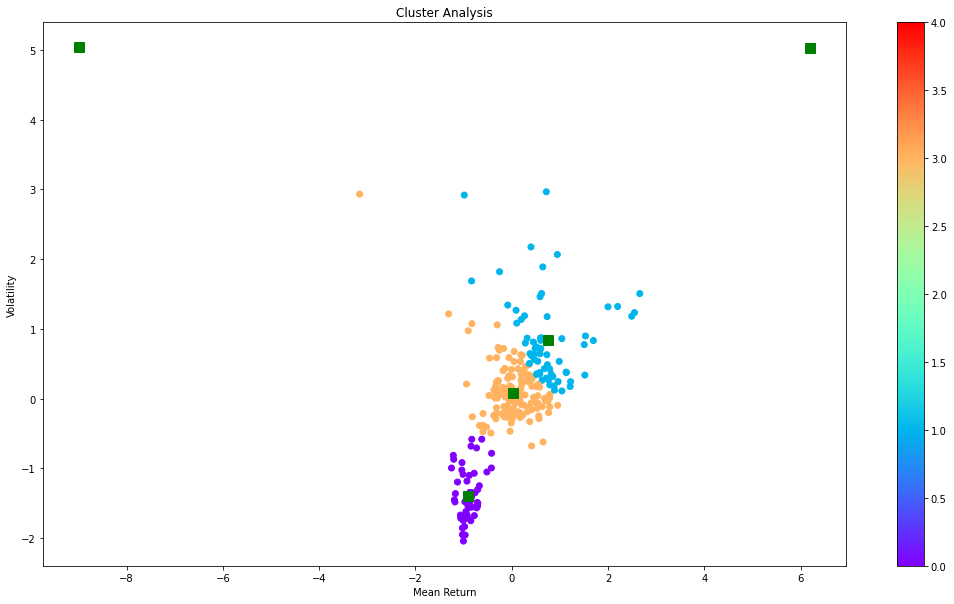

In [13]:
# show results
centroids = k_means.cluster_centers_
fig = plt.figure(figsize=(18,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0], X.iloc[:,1], c=k_means.labels_, cmap='rainbow', label=X.index )
ax.set_title('Cluster Analysis')
ax.set_ylabel('Volatility')
ax.set_xlabel('Mean Return')
plt.colorbar(scatter)
plt.plot(centroids[:,0], centroids[:,1], "sg", markersize=10)
plt.show()